# Extended Kalman Filter

## Introduction

Standard Kalman filter algorithm assume that the process and measurement models are linear and the noises are gaussian (uni-modal).

However, in most of the real world applications the models are not linear and in order to generalize the Kalman filtering for non-linear problems an approximation should be made for these non linear models.

Thats what I will explain in details in this post.

### Problem Formulation

First, we formulate the problem before digging into the solution and deriving of the new approximated Kalman filter.

lets assume that we have two sensor models where one is linear (function $h_1$) and other is non-linear (function $h_2$).

$$
    z_k = h_1 (x) = x
$$

$$
    z_k = h_2 (x) = x^2
$$


### Problem Visualization

The next step is to plot the curves for both models $h_1(x)$ and $h_2(x)$.

First, we need to generate $x_i$ samples in some range (eg. $[-20, +20]$) and propagate them through the function models to plot the output samples $z_i$

In [1]:
#from KF_Visualization import *
import numpy as np
import matplotlib.pyplot as plt
import scipy.stats as stats
import math

In [2]:
def f1(x):
    '''
    Linear function
    '''
    return x

def f2(x):
    '''
    Non-linear function
    '''
    return x**2

In [3]:
class KF_Visualization:
    def __init__(self, model, x_model_range, z_model_range, x_mean, x_sigma, samples_num=100, model_derivative=None):
        '''
        initialize the class object
        
        model : model to be used for projection
        
        x_model_range : min/max ranges for the x samples used for plotting model curve
        z_model_range : min/max ranges for the z samples used for plotting model curve
        x_mean : input mean
        x_sigma : input standard deviation
        '''
        self.inf = 1000000000
        
        self.xlim_min, self.xlim_max = x_model_range
        self.zlim_min, self.zlim_max = z_model_range
               
        self.x_mean = x_mean
        self.x_sigma = x_sigma
        
        self.z_mean = model(x_mean)
        self.z_sigma = None
        
        self.model = model
        self.model_derivative = model_derivative
        
        self.fig, self.axes = self.create_plot()
        
    def update_plot(self):
        '''
        main function to execute the class plotting
        '''
        self.axes[1, 1].set_xlim(self.xlim_min, self.xlim_max)
        self.axes[0, 1].set_xlim(self.xlim_min, self.xlim_max)
        self.axes[0, 1].set_ylim(self.zlim_min, self.zlim_max)
        self.axes[0, 0].set_ylim(self.zlim_min, self.zlim_max)
               
        # 1. plot input normal distribution
        x_norm_bel, p_norm_bel = self.generate_normal_samples(self.x_mean, self.x_sigma, 50)
        if self.model_derivative is None:
            z_norm_bel = self.model(x_norm_bel)
        else:
            z_norm_bel = self.model_derivative(x_norm_bel) * self.x_mean - self.z_mean
            
        x_norm_pts, p_norm_pts = self.generate_normal_samples(self.x_mean, self.x_sigma, 8)
        if self.model_derivative is None:
            z_norm_pts = self.model(x_norm_pts)
        else:
            z_norm_pts = self.model_derivative(x_norm_pts) * self.x_mean - self.z_mean
        
        self.plot_input_figure(x_norm_bel, p_norm_bel, x_norm_pts, p_norm_pts)
        self.plot_model_figure(x_norm_pts, z_norm_pts)
        self.plot_output_figure(z_norm_bel, p_norm_bel, z_norm_pts, p_norm_pts)
        
    def plot_input_figure(self, x_norm_bel, p_norm_bel, x_norm_pts, p_norm_pts):
        '''
        plot the projection input subplot figure on the top left side
        '''
        self.axes[1, 1].plot(x_norm_bel, p_norm_bel, color='blue')
        self.plot_v_norm_projection(self.axes[1, 1], x_norm_pts, p_norm_pts, color='red', label='', linestyle=':', direction='up')
        
    def plot_model_figure(self, x_norm_pts, z_norm_pts):
        '''
        plot function curve on the top right subplot figure
        '''       
        x_model = np.linspace(self.xlim_min, self.xlim_max, num=100)
        z_model = self.model(x_model)
        
        self.axes[0, 1].plot(x_model, z_model, color='green')
        
        if self.model_derivative is not None:
            z_model_derivative = self.model_derivative(x_model) * self.x_mean - self.z_mean
            self.axes[0, 1].plot(x_model, z_model_derivative, color='orange')

        self.plot_v_norm_projection(self.axes[0, 1], x_norm_pts, z_norm_pts, color='red', label='', linestyle=':', direction='down')
        self.plot_h_norm_projection(self.axes[0, 1], x_norm_pts, z_norm_pts, color='red', label='', linestyle=':', direction='left')
        
    def plot_output_figure(self, z_norm_bel, p_norm_bel, z_norm_pts, p_norm_pts):
        '''
        plot the projection output subplot figure on the top left side
        '''
        self.axes[0, 0].plot(p_norm_bel, z_norm_bel, color='blue')
        self.plot_h_norm_projection(self.axes[0, 0], p_norm_pts, z_norm_pts, color='red', label='', linestyle=':', direction='right')
        
    def create_plot(self):
        '''
        create and prepare the 3 subplot figures to be used by the KF visualizer
        '''
        fig, axes = plt.subplots(2, 2, figsize=(20, 10))

        axes[1, 0].set_axis_off()

        axes[0, 0].set_xlim(0., 1.)
        axes[1, 1].set_ylim(0., 1.)

        axes[0, 0].axvline(c='grey', lw=2)
        axes[0, 0].axhline(c='grey', lw=2)

        axes[0, 1].axvline(c='grey', lw=2)
        axes[0, 1].axhline(c='grey', lw=2)

        axes[1, 1].axvline(c='grey', lw=2)
        axes[1, 1].axhline(c='grey', lw=2)

        axes[0, 0].grid(visible=True)
        axes[0, 1].grid(visible=True)
        axes[1, 1].grid(visible=True)

        axes[0, 1].set_title('Function Model f', fontsize=30)

        axes[0, 0].set_xlabel('p(z)', fontsize=30)
        axes[0, 0].set_ylabel('output z', fontsize=30)
        
        axes[1, 1].set_xlabel('input x', fontsize=30)
        axes[1, 1].set_ylabel('p(x)', fontsize=30)
        
        return fig, axes
    
    def generate_normal_samples(self, mu, sigma, num):
        '''
        generate normally distributed 1D [samples, pdfs] such that the mean value
        is included as well in the middle index of the array.
        '''
        sigma_3 = 3*sigma
        x = np.linspace(mu - sigma_3, mu + sigma_3, num)
        middle_idx = int(num / 2)
        x = np.insert(x, middle_idx, mu) # add the mean value to the samples in the correct order of points (middle)
        p = stats.norm.pdf(x, mu, sigma)
        return x, p

    def plot_v_norm_projection(self, ax, xlist, ylist, color, label, linestyle, direction='up'):
        '''
        draw a vertical line/lines projecting point/points either up or down directions
        '''
        ax.plot(xlist, ylist, color=color, marker='o', linestyle='') # draw point
        if direction != 'up':
            ax.vlines(xlist, -self.inf, ylist, color=color, label=label, linestyle=linestyle)
        else:
            ax.vlines(xlist, ylist, self.inf, color=color, label=label, linestyle=linestyle)

    def plot_h_norm_projection(self, ax, xlist, ylist, color, label, linestyle, direction='right'):
        '''
        draw a horizontal line/lines projecting point/points either right or left directions
        '''
        ax.plot(xlist, ylist, color=color, marker='o', linestyle='') # draw point
        if direction != 'right':
            ax.hlines(ylist, -self.inf, xlist, color=color, label=label, linestyle=linestyle)
        else:
            ax.hlines(ylist, xlist, self.inf, color=color, label=label, linestyle=linestyle)


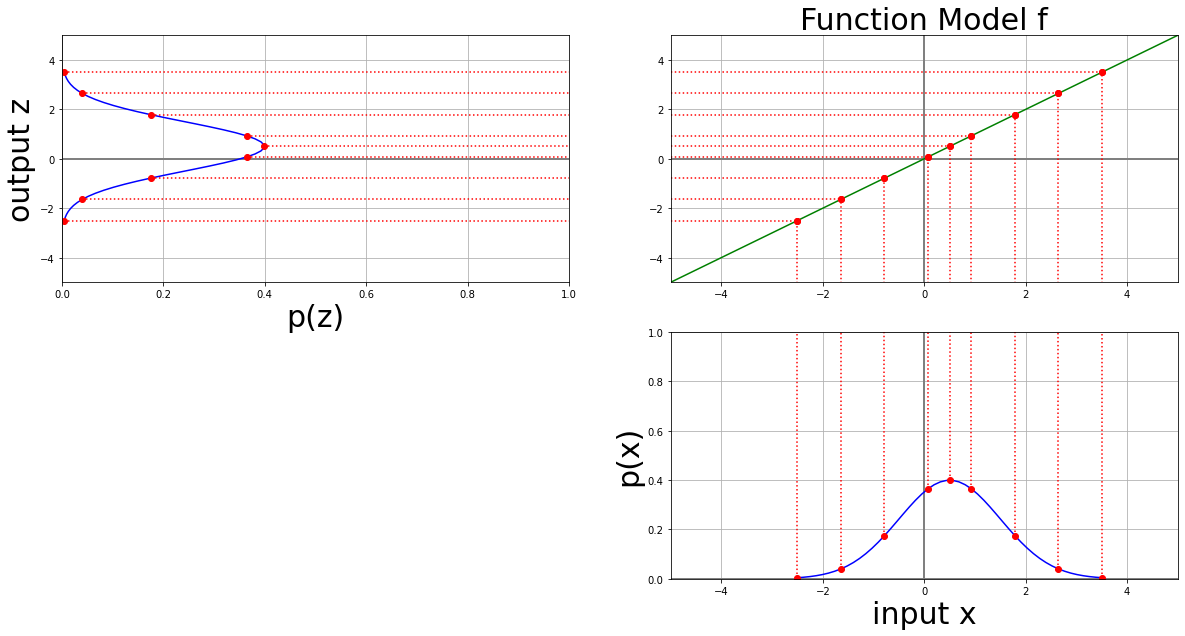

In [4]:
x_range, x_num = (-5., 5.), 100
z_range = (-5., 5.)
x_mean, x_sigma = 0.5, 1.0

kf_visu = KF_Visualization(f1, x_range, z_range, x_mean, x_sigma)
kf_visu.update_plot()

When a normally distributed samples propagated through a linear model, the propagated output samples are also normally distributed.

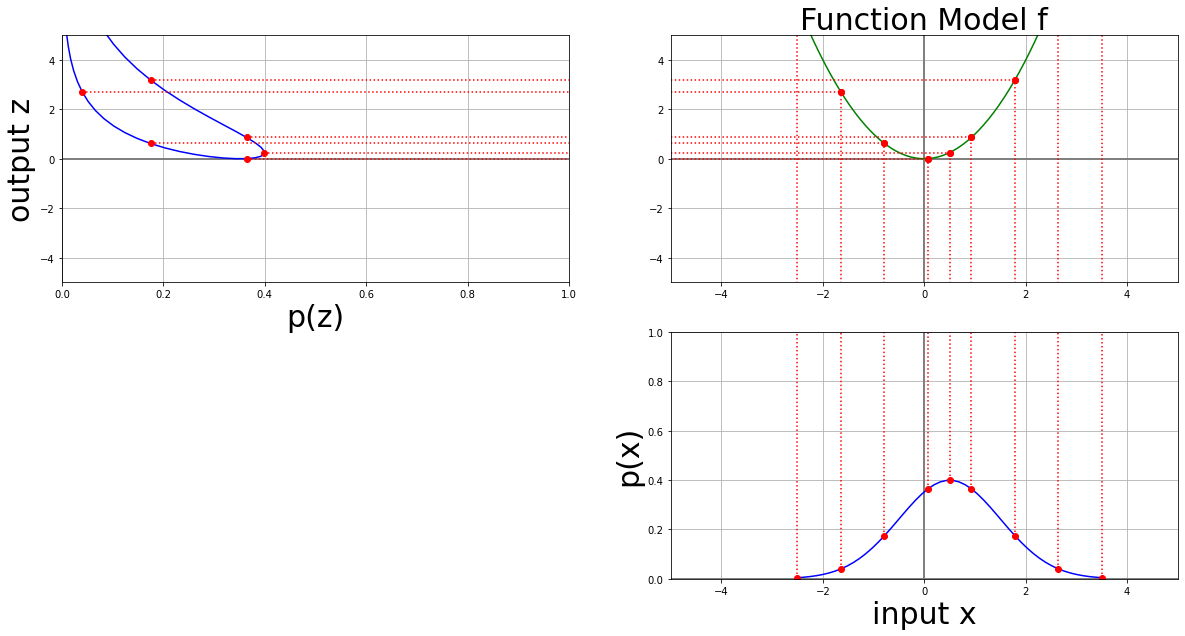

In [5]:
x_range, x_num = (-5., 5.), 100
z_range = (-5., 5.)
x_mean, x_sigma = 0.5, 1.0

kf_visu = KF_Visualization(f2, x_range, z_range, x_mean, x_sigma)
kf_visu.update_plot()

On the other hand, When a normally distributed samples propagated through a non-linear model, the propagated output samples are distorted and no normally distributed anymore as seen in the above figure.

To fix the alignment of the propagated output samples in order to be normally distributed, a simple approach which could also work for many of the real world non-linear systems is to linearize the model about the point of interest and then propagate the input samples through this linearized model.

A very popular technique to do linearization is the taylor expansion:

$$
\sum_{n=0}^{\infty} \frac{f^{(n)}(a)}{n!} (x-a)^n
$$

where $n!$ is the factorial of $n$, $a$ is a real number point of interest, and $f^{(n)}(a)$ is the $nth$ derivative of function $f(a)$ evaluated at point $a$.

The summation in above equation can be expanded to be:

$$
f(a) + \frac{f^{(1)}(a)}{1!} (x-a) + \frac{f^{(2)}(a)}{2!} (x-a)^2 + \frac{f^{(3)}(a)}{3!} (x-a)^3 + \cdots
$$

In our case, we are interested in the first derivative of the function so we are more focusing on these terms:

$$
    f(a) + \frac{\partial{f(a)}}{\partial{x}} (x - a)
$$

where,

$$
f^{(1)}(a) = \frac{\partial{f(a)}}{\partial{x}}
$$

In [6]:
def f2_derivative(x):
    return 2*x

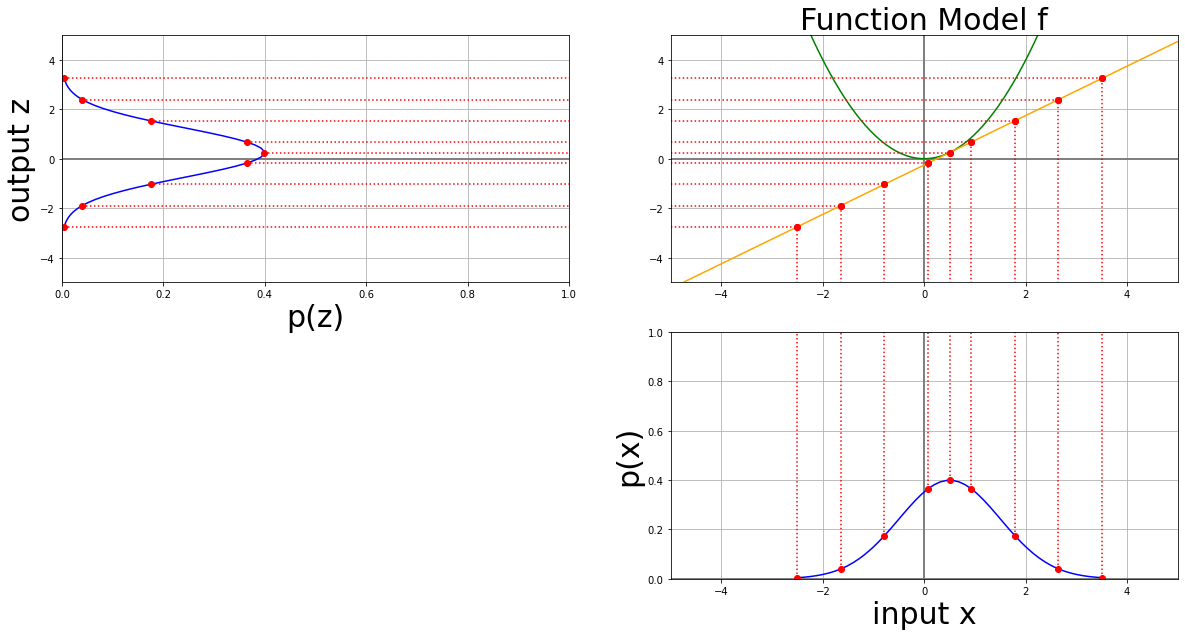

In [7]:
x_range, x_num = (-5., 5.), 100
z_range = (-5., 5.)
x_mean, x_sigma = 0.5, 1.0

kf_visu = KF_Visualization(f2, x_range, z_range, x_mean, x_sigma, 100, f2_derivative)
kf_visu.update_plot()

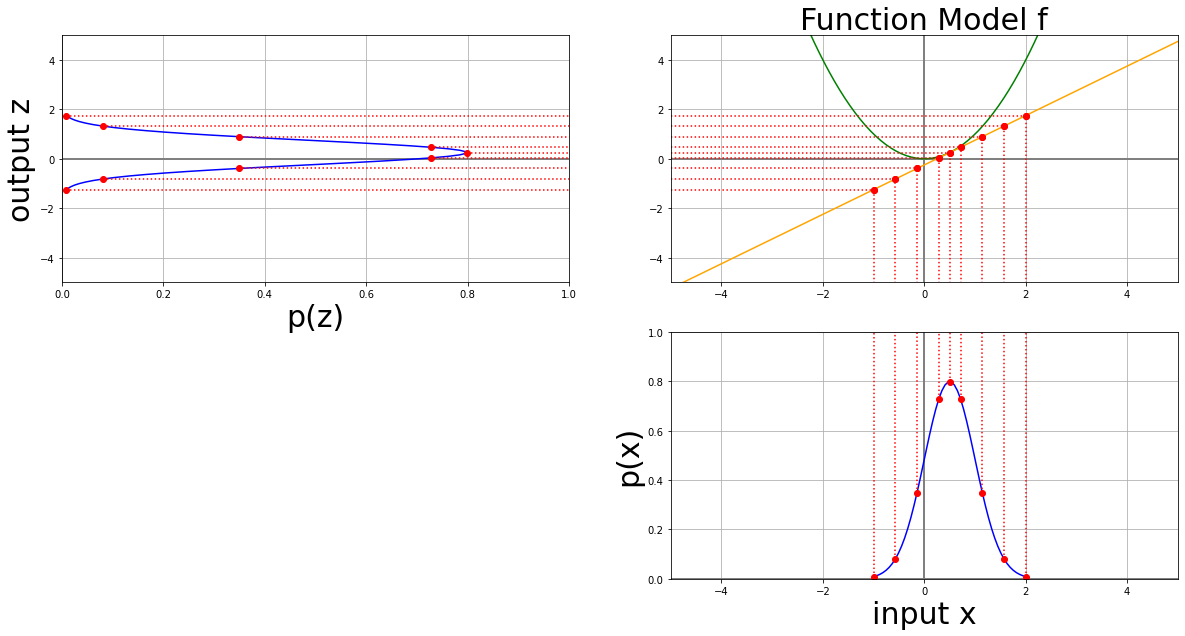

In [8]:
x_range, x_num = (-5., 5.), 100
z_range = (-5., 5.)
x_mean, x_sigma = 0.5, 0.5

kf_visu = KF_Visualization(f2, x_range, z_range, x_mean, x_sigma, 100, f2_derivative)
kf_visu.update_plot()

Now, the input samples are propagrated through the linearized model instead of the non-linear model, and as a result the propagated output samples are still normally distributed.

However, there is a still a drawback when the model non-linearity is high makes the linearized straight line approximate correctly for a very small path from the original non-linear equation. This implies that the samples drawn far from the point of interest will probably deviate much from the actual non-linear model and won't apprixmate correctly.

## Example

Lets practice an example from a real application and see how the equations are formulated.

Assume we have a Radar sensor that measures for us the range $r$ and bearing $\beta$ of a target. The state that we are estimating is the cartesian coordinates of the target in $x$ and $y$ components.

![](images/sensorA_and_sensorB.PNG)

The measurement model will be the trignometric equations used to convert from cartesian to polar coordinates:

$$
\vec{z}_{k|k-1} = h(\vec{x}_{k|k-1})
$$

$$
\begin{bmatrix} r \\ \beta \end{bmatrix} = \begin{bmatrix} h_1 \\ h_2 \end{bmatrix} = \begin{bmatrix} \sqrt{p_{x,{k|k-1}}^2 + p_{y,{k|k-1}}^2} \\ \tan^{-1} \left( \frac{p_{y,{k|k-1}}}{p_{x,{k|k-1}}} \right) \end{bmatrix}
$$

Lets assume that our predicted state and covariance are:

$$
    \vec{x}_{k|k-1} = \begin{bmatrix} p_{x,k|k-1} \\ p_{y, k|k-1}\end{bmatrix} = \begin{bmatrix} 10 \\ 5\end{bmatrix}
$$

$$
    P_{k|k-1} = \begin{bmatrix} q_{11} & q_{12} \\ q_{21} & q_{22}\end{bmatrix} = \begin{bmatrix} 0.3 & 0.03 \\ 0.03 & 0.3\end{bmatrix}
$$

and the received measurement is:

$$
    \vec{z}_{k} = \begin{bmatrix} r_{k} \\ \beta_{k}\end{bmatrix} = \begin{bmatrix} 12.0 \\ 0.55\end{bmatrix}
$$

$$
    R = \begin{bmatrix} r_{11} & r_{12} \\ r_{21} & r_{22}\end{bmatrix} = \begin{bmatrix} 0.1 & 0 \\ 0 & 0.1\end{bmatrix}
$$

In [28]:
import sys

In [55]:
def h(x):
    '''
    nonlinear measurement model for range sensor
    x : input state vector [2 x 1] ([0]: p_x, [1]: p_y)
    z : output measurement vector [2 x 1] ([0]: range, [1]: bearing )
    '''
    z = np.zeros((2, 1))
    z[0] = np.sqrt(x[0]**2 + x[1]**2)
    z[1] = np.arctan(x[1] / (x[0] + sys.float_info.epsilon))
    return z

In [66]:
class RangeMeasurement:
    def __init__(self, position):
        self.range = np.sqrt(position[0]**2 + position[1]**2)
        self.bearing = np.arctan(position[1] / (position[0] + sys.float_info.epsilon))
        self.position = np.array([[position[0]],[position[1]]])

    def actual_position(self):
        return self.position
        
    def asArray(self):
        return np.array([[self.range],[self.bearing]])
        
    def show(self):
        print(f'range: {self.range}')
        print(f'bearing: {self.bearing}')

In [67]:
measurement = RangeMeasurement((10.4, 5.2))
measurement.show()

range: 11.627553482998907
bearing: 0.4636476090008061


## Calculating the Jacobians

To calculate the Jacobian of the measurement model, we have to calculate the partical derivatives of each equation $h_1$ and $h_2$ with respect to each state $x_1$ and $x_2$.

$$
H_j = \begin{bmatrix} \frac{\partial{h_1}}{\partial p_x} & \frac{\partial{h_1}}{\partial p_y} \\ \frac{\partial{h_2}}{\partial p_x} & \frac{\partial{h_2}}{\partial p_y}\end{bmatrix}
$$

$$
\begin{align}
    \frac{\partial{h_1}}{\partial p_x}
    &= \frac{\partial{}}{\partial p_x} \sqrt{p_{x,{k|k-1}}^2 + p_{y,{k|k-1}}^2} \\
    &= \frac{\partial{}}{\partial p_x} (p_{x,{k|k-1}}^2 + p_{y,{k|k-1}}^2)^{\frac{1}{2}} \\
    &= \frac{2 p_{x,{k|k-1}}}{2 \sqrt{p_{x,{k|k-1}}^2 + p_{y,{k|k-1}}^2}} \\
    &= \frac{p_{x,{k|k-1}}}{\sqrt{p_{x,{k|k-1}}^2 + p_{y,{k|k-1}}^2}}
\end{align}
$$

$$
\begin{align}
    \frac{\partial{h_1}}{\partial p_y}
    &= \frac{\partial{}}{\partial p_y} \sqrt{p_{x,{k|k-1}}^2 + p_{y,{k|k-1}}^2} \\
    &= \frac{\partial{}}{\partial p_y} (p_{x,{k|k-1}}^2 + p_{y,{k|k-1}}^2)^{\frac{1}{2}} \\
    &= \frac{2 p_{y,{k|k-1}}}{2 \sqrt{p_{x,{k|k-1}}^2 + p_{y,{k|k-1}}^2}} \\
    &= \frac{p_{y,{k|k-1}}}{\sqrt{p_{x,{k|k-1}}^2 + p_{y,{k|k-1}}^2}}
\end{align}
$$

$$
\begin{align}
    \frac{\partial{h_2}}{\partial p_x}
    &= \frac{\partial{}}{\partial p_x} \arctan \left( \frac{p_{y,{k|k-1}}}{p_{x,{k|k-1}}} \right) \\
    &= \frac{-p_{y,{k|k-1}}}{p_{x,{k|k-1}}^2+p_{y,{k|k-1}}^2}
\end{align}
$$

$$
\begin{align}
    \frac{\partial{h_2}}{\partial p_y}
    &= \frac{\partial{}}{\partial p_y} \arctan \left( \frac{p_{y,{k|k-1}}}{p_{x,{k|k-1}}} \right) \\
    &= \frac{p_{x,{k|k-1}}}{p_{x,{k|k-1}}^2+p_{y,{k|k-1}}^2}
\end{align}
$$

Substitute all elements in the Jacobian matrix to be:

$$
H_j =
\begin{bmatrix}
\frac{p_{x,{k|k-1}}}{\sqrt{p_{x,{k|k-1}}^2 + p_{y,{k|k-1}}^2}} & \frac{p_{y,{k|k-1}}}{\sqrt{p_{x,{k|k-1}}^2 + p_{y,{k|k-1}}^2}} \\
\frac{-p_{y,{k|k-1}}}{p_{x,{k|k-1}}^2+p_{y,{k|k-1}}^2} & \frac{p_{x,{k|k-1}}}{p_{x,{k|k-1}}^2+p_{y,{k|k-1}}^2}
\end{bmatrix}
$$

In [68]:
def calculate_jacobian_H(x):
    '''
    nonlinear measurement model for range sensor
    x : input state vector [2 x 1] ([0]: p_x, [1]: p_y)
    Hj : output jacobian matrix [2 x 2}
    '''
    x2_plus_y2 = x[0]**2 + x[1]**2
    sqrt_x2_plus_y2 = np.sqrt(x2_plus_y2)
    
    Hj = np.zeros((2, 2))
    Hj[0, 0] = x[0] / sqrt_x2_plus_y2
    Hj[0, 1] = x[1] / sqrt_x2_plus_y2
    Hj[1, 0] = -x[1] / x2_plus_y2
    Hj[1, 1] = x[0] / x2_plus_y2
    
    return Hj

In [69]:
# preparing Kalman filter inputs

x = np.array([[10.],[5.]])
P = np.array([[0.3, 0.0],[0.0, 0.3]])

z = measurement.asArray()
R = np.array([[0.1, 0.0],[0.0, 0.0008]])

Hj = calculate_jacobian_H(x)

# find measurement noise covariance given that you know the uncertainty
# of the sensor but in x/y coordinates, so convert it to range and bearing
# domain
R = np.array([[0.1, 0.0],[0.0, 0.1]])
R = Hj @ R @ Hj.T
print(f'measurement covariance R = \n{R}')

measurement covariance R = 
[[0.1    0.    ]
 [0.     0.0008]]


In [70]:
def correct_ekf(x, P, z, R, h, Hj):
    I = np.eye(len(P)) # identity matrix
    S = Hj @ P @ Hj.T + R # innovation covariance
    K = P @ Hj.T @ np.linalg.pinv(S) # kalman gain
    z_hat = h(x) # predicted measurement
    x = x + K @ (z - z_hat) # posterior state
    P = (I - K @ Hj) @ P # posterior covariance
    return x, P, z_hat, S

In [71]:
# execute EKF measurement step
x_post, P_post, z_prior, S_prior = correct_ekf(x, P, z, R, h, Hj)

# calculate the corrected state but in the innovation dimension
# before plot along with actual measurement and predicted measurement
# for comparison purpose.
z_post = h(x_post)
S_post = Hj @ P_post @ Hj.T #+ R

print(f'prior x = \n{x}')
print(f'prior P = \n{P}')

prior x = 
[[10.]
 [ 5.]]
prior P = 
[[0.3 0. ]
 [0.  0.3]]


In [72]:
# prepare helper functions for visualizing the ellipses
from matplotlib.patches import Ellipse

def create_covariance_ellipse(pos, cov):
    # https://www.visiondummy.com/2014/04/draw-error-ellipse-representing-covariance-matrix
    eig_values, eig_vectors = np.linalg.eig(cov)
    
    scale_95 = np.sqrt(5.991)
    radius_1 = scale_95 * eig_values[0]
    radius_2 = scale_95 * eig_values[1]
    angle = np.arctan2(eig_vectors[1, 1], eig_vectors[0, 1])
    
    return radius_1, radius_2, angle

def draw_ellipse(ax, mu, radius_1, radius_2, angle, color):
    # https://matplotlib.org/stable/gallery/shapes_and_collections/ellipse_demo.html
    ellipse = Ellipse(
        mu,
        width=radius_1 * 2,
        height=radius_2 * 2,
        angle=np.rad2deg(angle) + 90,
        facecolor=color,
        alpha=0.4)
    ax.add_artist(ellipse)
    return ax

def plot_ellipse(ax, x, P, color):
    x = x[0:2].reshape(2,)
    P = P[0:2, 0:2]
    r1, r2, angle = create_covariance_ellipse(x, P)
    draw_ellipse(ax, x, r1, r2, angle, color)
    
def get_correlated_dataset(n, cov, mu, scale):
    # https://carstenschelp.github.io/2018/09/14/Plot_Confidence_Ellipse_001.html
    latent = np.random.randn(n, 2)
    cov = latent.dot(cov)
    scaled = cov * scale
    scaled_with_offset = scaled + mu
    # return x and y of the new, correlated dataset
    return scaled_with_offset[:, 0], scaled_with_offset[:, 1]

def plot_samples(ax, samples_num, x, P, color, markersize, label):
    scale = 1, 1
    x, y = get_correlated_dataset(samples_num, P, x, scale)
    ax.scatter(x, y, s=markersize, marker='x', c=color, label=label)
    
def plot_mean(ax, x, size, color, label):
    ax.scatter(x[0], x[1], s=size, marker='o', c=color, label=label)
    
def plot_state(ax, x, P, samples_num, markersize, color, label):
    x = x[0:2].reshape(2,)
    P = P[0:2, 0:2]
    
    plot_ellipse(ax, x, P, color)
    plot_samples(ax, samples_num, x, P, color, markersize, label+'_possibilities')
    plot_mean(ax, x, 100, color, label+'_mean')
    
def create_viewer(title, xlabel, ylabel, xlim=None, ylim=None):
    fig, viewer = plt.subplots(figsize=(20, 10))
    
    viewer.set_title(title, fontsize=20, color='green', fontweight='bold')
    
    viewer.axvline(c='grey', lw=2)
    viewer.axhline(c='grey', lw=2)

    viewer.set_xlabel(xlabel, fontsize=20, fontweight ='bold')
    viewer.set_ylabel(ylabel, fontsize=20, fontweight ='bold')
    
    if (xlim != None):
        viewer.set_xlim(xlim[0], xlim[1])
    
    if (ylim != None):
        viewer.set_ylim(ylim[0], ylim[1])
    
    return viewer

def visualize_estimate(viewer, label, color, x, P):
    print(label+' x', x, '\n')
    print(label+' P', P, '\n') 
    plot_state(viewer, x=x, P=P, samples_num=500, markersize=1, color=color, label=label)
    
def update_plotter():
    plt.grid(visible=True)
    plt.legend(loc='upper right')
    plt.show()

predicted measurement z x [[11.18033989]
 [ 0.46364761]] 

predicted measurement z P [[0.4    0.    ]
 [0.     0.0032]] 

actual measurement z x [[11.62755348]
 [ 0.46364761]] 

actual measurement z P [[0.1    0.    ]
 [0.     0.0008]] 

corrected measurement z x [[11.51575008]
 [ 0.46364761]] 

corrected measurement z P [[0.075  0.    ]
 [0.     0.0006]] 



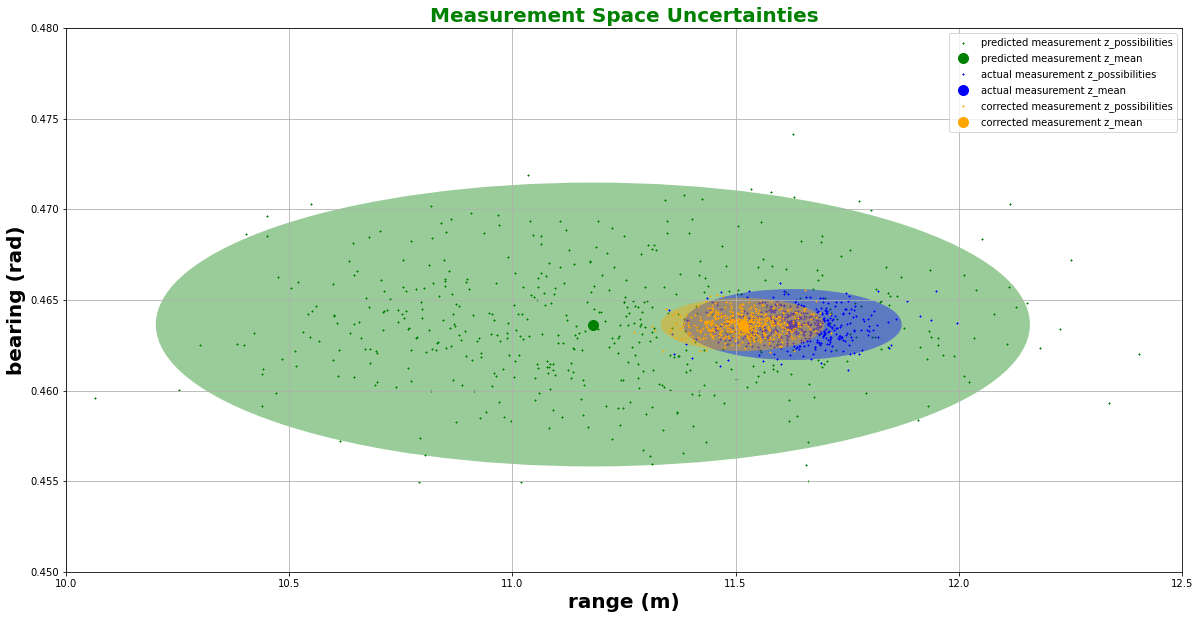

In [73]:
viewer = create_viewer('Measurement Space Uncertainties', 'range (m)', 'bearing (rad)', xlim=(10,12.5), ylim=(0.45,.48))

visualize_estimate(viewer, 'predicted measurement z', 'g', z_prior, S_prior)
visualize_estimate(viewer, 'actual measurement z', 'b', z, R)
visualize_estimate(viewer, 'corrected measurement z', 'orange', z_post, S_post)

update_plotter()

actual state [[10.4]
 [ 5.2]]
Initial State x x [[10.]
 [ 5.]] 

Initial State x P [[0.3 0. ]
 [0.  0.3]] 

Estimated State x x [[10.3 ]
 [ 5.15]] 

Estimated State x P [[0.075 0.   ]
 [0.    0.075]] 



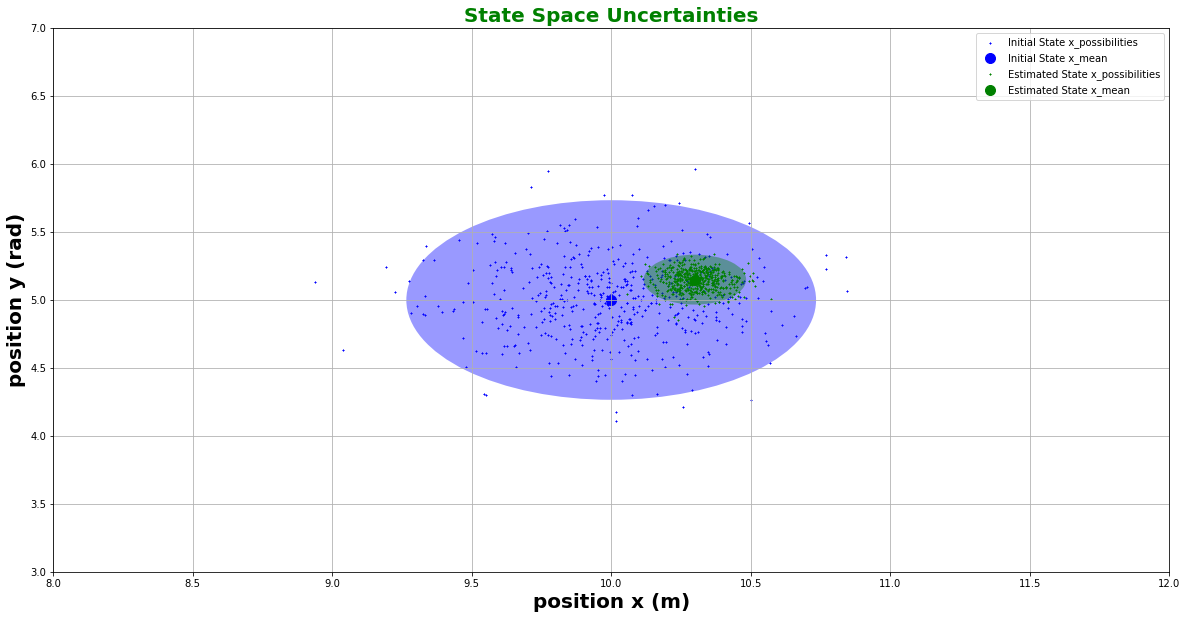

In [75]:
viewer = create_viewer('State Space Uncertainties', 'position x (m)', 'position y (rad)', xlim=(8,12), ylim=(3,7))

print('actual state', measurement.actual_position())
visualize_estimate(viewer, 'Initial State x', 'b', x, P)
visualize_estimate(viewer, 'Estimated State x', 'g', x_post, P_post)

update_plotter()